# Домашнее задание 3

В файле `games.csv` собран датасет по посещаемости 80 популярных игр (да-да, аналогично предыдущей дз). Нам нужен был достаточно гомогенный датасет. Так как посещаемость в первые дни после выхода игры обычно аномальная, рекомендуется внимательно посмотреть на начало рядов и при необходимости отсечь часть стартовых наблюдений.

# 1. SARIMA (2 балла)

Для этого раздела выберите наиболее близкую вам игру, или же возьмите случайную. Во всех рядах возьмём недельную сезонность с периодом 7. Она по структуре данных ожидается наиболее сильной.

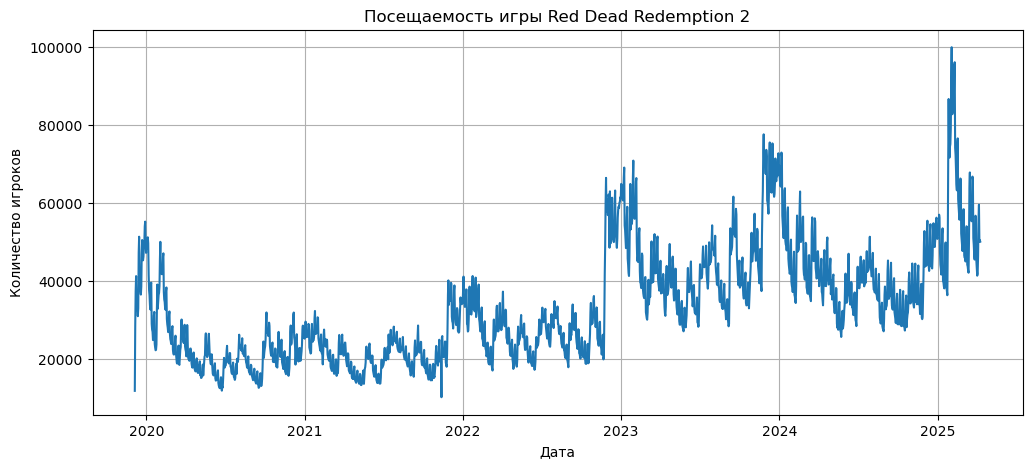

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

df = pd.read_csv('games.csv', parse_dates=['DateTime'], index_col='DateTime')

game = 'Red Dead Redemption 2'
ts = df[game].dropna()

plt.figure(figsize=(12, 5))
plt.plot(ts)
plt.title(f'Посещаемость игры {game}')
plt.xlabel('Дата')
plt.ylabel('Количество игроков')
plt.grid()
plt.show()

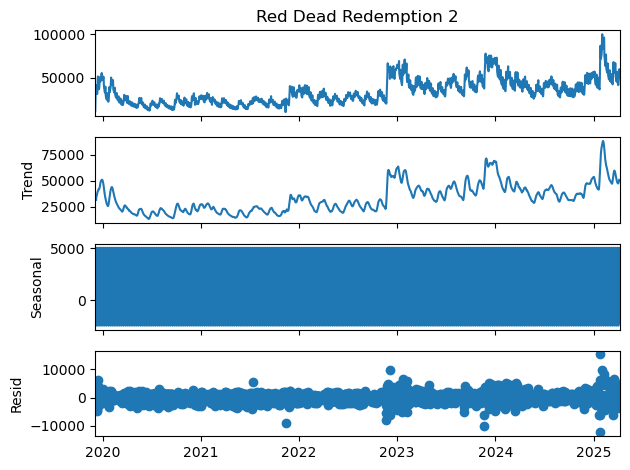

In [2]:
decomposition = seasonal_decompose(ts, period=7, model='additive')
decomposition.plot()
plt.show()


(0.5 балла)
Отберите параметр D на основе силы сезонности STL.

In [3]:
from statsmodels.tsa.seasonal import STL
import numpy as np

stl = STL(ts, period=7)
res = stl.fit()

seasonal_var = np.var(res.seasonal)
resid_var = np.var(res.resid)
Fs = max(0, 1 - resid_var / (seasonal_var + resid_var))

print(f"Сила сезонности (Fs): {Fs:.3f}")

Сила сезонности (Fs): 0.877


FS > 0.6 => сезонность значимая => D=1

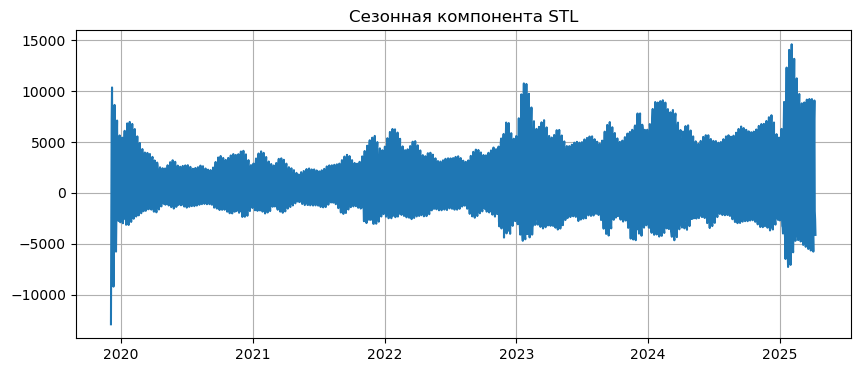

In [4]:
plt.figure(figsize=(10, 4))
plt.plot(res.seasonal)
plt.title("Сезонная компонента STL")
plt.grid()
plt.show()


(0.5 балла) Отберите параметр d на основе ADF или KPSS. Убедитесь, что правильно специфицировали тесты. Аргументируйте ваш выбор. Ваша спецификация должна быть согласована со структурой данных.

In [5]:
from statsmodels.tsa.stattools import adfuller, kpss
import numpy as np

def select_d(series, max_d=2):
    for d in range(max_d + 1):
        if d > 0:
            diff_series = series.diff(d).dropna()
        else:
            diff_series = series.copy()
        
        adf_result = adfuller(diff_series, regression='ct', autolag='AIC')
        adf_p = adf_result[1]

        kpss_result = kpss(diff_series, regression='ct', nlags='auto')
        kpss_p = kpss_result[1]
        
        print(f"d={d}: ADF p-value={adf_p:.3f}, KPSS p-value={kpss_p:.3f}")
        
        #остановка
        if adf_p < 0.05 and kpss_p > 0.05:
            print(f"Ряд стационарен при d={d}")
            return d
    
    print("Ряд не удалось сделать стационарным при max_d={max_d}")
    return None

d = select_d(ts)

d=0: ADF p-value=0.007, KPSS p-value=0.010
d=1: ADF p-value=0.000, KPSS p-value=0.100
Ряд стационарен при d=1


/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_10259/1250397396.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(diff_series, regression='ct', nlags='auto')
/var/folders/42/9cgz73ss3qzdqc049vnjqf6m0000gp/T/ipykernel_10259/1250397396.py:14: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(diff_series, regression='ct', nlags='auto')


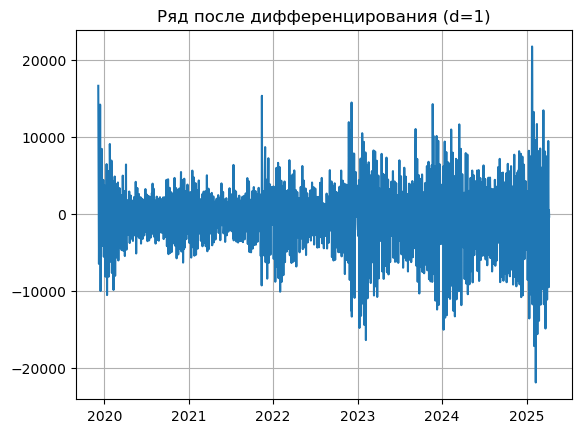

In [6]:
plt.plot(ts.diff().dropna())
plt.title("Ряд после дифференцирования (d=1)")
plt.grid()
plt.show()

(0.5 балла) Примените к ряду разности согласно D и d. Изобразите ACF и PACF для стационарного ряда. 

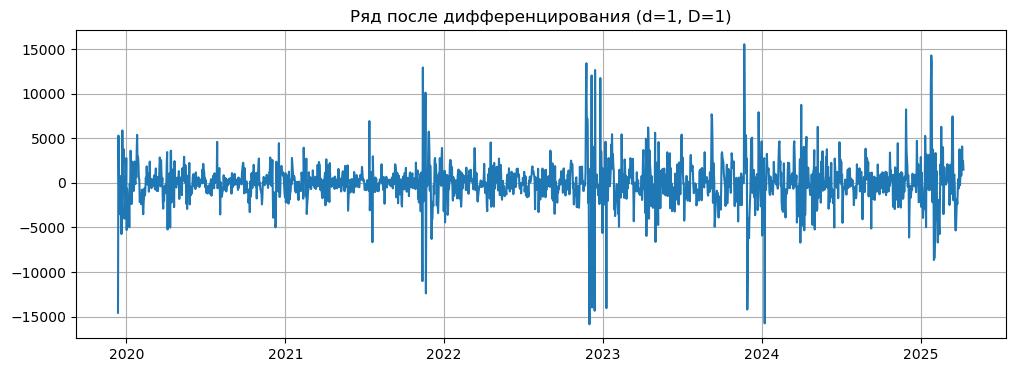

In [7]:
ts_diff = ts.diff().dropna()

ts_diff_seasonal = ts_diff.diff(7).dropna()

plt.figure(figsize=(12, 4))
plt.plot(ts_diff_seasonal)
plt.title("Ряд после дифференцирования (d=1, D=1)")
plt.grid()
plt.show()

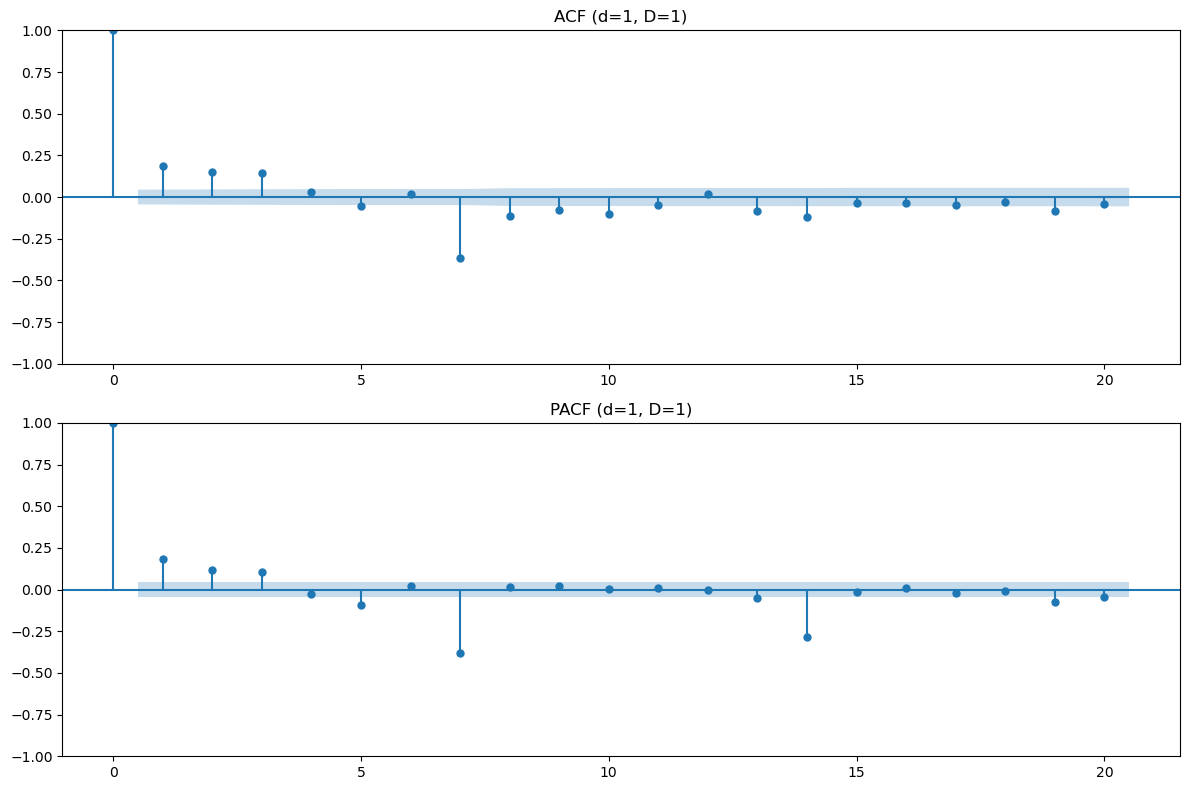

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(ts_diff_seasonal, lags=20, ax=ax1, title="ACF (d=1, D=1)")
plot_pacf(ts_diff_seasonal, lags=20, ax=ax2, title="PACF (d=1, D=1)", method='ywm')
plt.tight_layout()
plt.show()

(0.5) Определите по коррелограммам параметры P,Q,p,q или их границы в случае неоднозначности. Подберите оптимальные параметры по AIC. Длину трейна и горизонт прогнозирования специфицируйе самостоятельно, выбор обоснуйте.

ACF и PACF затухают после лага 1 => q=1 и p=1\
На обеих коррелограммах видим пики на лаге 7 => Q=1, P=1

In [9]:
ts_train = ts.iloc[:-14]
ts_test = ts.iloc[-14:]

print(f"Трейн: {len(ts_train)} точек, Тест: {len(ts_test)} точек")

Трейн: 1939 точек, Тест: 14 точек


14 дней достаточно для проверки качества прогноза на 1–2 сезонных периодах.\
Уменьшение горизонта (например, 7 дней) может не выявить долгосрочные ошибки модели.

In [10]:
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings

warnings.filterwarnings('ignore')

p_range = [0, 1, 2]
q_range = [0, 1, 2]
P_range = [0, 1]
Q_range = [0, 1]

best_aic = float('inf')
best_params = None

for p, q, P, Q in itertools.product(p_range, q_range, P_range, Q_range):
    try:
        model = SARIMAX(ts_train,
                        order=(p, 1, q),
                        seasonal_order=(P, 1, Q, 7),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=0)
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_params = (p, q, P, Q)
        print(f"ARIMA({p},1,{q})({P},1,{Q})[7] — AIC: {aic:.2f}")
    except:
        continue
print(f"\nЛучшие параметры: p={best_params[0]}, q={best_params[1]}, P={best_params[2]}, Q={best_params[3]} (AIC={best_aic:})")

ARIMA(0,1,0)(0,1,0)[7] — AIC: 35383.96
ARIMA(0,1,0)(0,1,1)[7] — AIC: 34499.34
ARIMA(0,1,0)(1,1,0)[7] — AIC: 34984.50
ARIMA(0,1,0)(1,1,1)[7] — AIC: 34470.39
ARIMA(0,1,1)(0,1,0)[7] — AIC: 35302.59
ARIMA(0,1,1)(0,1,1)[7] — AIC: 34543.39
ARIMA(0,1,1)(1,1,0)[7] — AIC: 34936.11
ARIMA(0,1,1)(1,1,1)[7] — AIC: 34365.31
ARIMA(0,1,2)(0,1,0)[7] — AIC: 35265.05
ARIMA(0,1,2)(0,1,1)[7] — AIC: 34383.51
ARIMA(0,1,2)(1,1,0)[7] — AIC: 34919.08
ARIMA(0,1,2)(1,1,1)[7] — AIC: 34347.77
ARIMA(1,1,0)(0,1,0)[7] — AIC: 35318.31
ARIMA(1,1,0)(0,1,1)[7] — AIC: 34416.10
ARIMA(1,1,0)(1,1,0)[7] — AIC: 34898.63
ARIMA(1,1,0)(1,1,1)[7] — AIC: 34532.35
ARIMA(1,1,1)(0,1,0)[7] — AIC: 35259.62
ARIMA(1,1,1)(0,1,1)[7] — AIC: 34376.52
ARIMA(1,1,1)(1,1,0)[7] — AIC: 34862.28
ARIMA(1,1,1)(1,1,1)[7] — AIC: 34344.25
ARIMA(1,1,2)(0,1,0)[7] — AIC: 35236.17
ARIMA(1,1,2)(0,1,1)[7] — AIC: 34362.19
ARIMA(1,1,2)(1,1,0)[7] — AIC: 34864.65
ARIMA(1,1,2)(1,1,1)[7] — AIC: 34349.92
ARIMA(2,1,0)(0,1,0)[7] — AIC: 35263.85
ARIMA(2,1,0)(0,1,1)[7] — 

Как мы видим я был прав

# 2. Проверка гомогенности (2 балла)

Попробуем понять, достаточно ли однороден наш датасет. Будем использовать все ряды из датасета. Для ускорения расчётов ресэмплируйте дневные данные к недельным с помощью усреднения. В этом разделе будем оценивать только модели без сезонности, так как при усреднении она исчезнет.

Разделите данные на трейн и тест. Последние 16 недель каждого ряда будут тестовой выборкой.

In [15]:
df = pd.read_csv('games.csv', parse_dates=['DateTime'], index_col='DateTime')

df_weekly = df.resample('W').mean()

In [16]:
def split_train_test(data, test_weeks=16):
    return data.iloc[:-test_weeks], data.iloc[-test_weeks:]

train_data = {}
test_data = {}

for game in df_weekly.columns:
    train, test = split_train_test(df_weekly[game])
    train_data[game] = train
    test_data[game] = test

(0.5 балла) Оцените автоматическую ARIMA на трейне каждого ряда. Можете использовать nixtla или pmdarima. Сохраните результат оценки. 

In [17]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima

warnings.filterwarnings('ignore')


arima_results = {}

for game in df_weekly.columns:
    print(f"\n--- Обработка игры: {game} ---")
    train, test = split_train_test(df_weekly[game].dropna())
    
    try:
        model = auto_arima(
            train,
            seasonal=False,
            stepwise=True,
            suppress_warnings=True,
            trace=True,
            error_action='ignore'
        )
        
        arima_results[game] = {
            'order': model.order,
            'aic': model.aic(),
            'forecast': model.predict(n_periods=16)
        }
        print(f"Лучшая модель: ARIMA{model.order} (AIC={model.aic():.2f})")
    
    except Exception as e:
        print(f"Ошибка для {game}: {e}")
        arima_results[game] = None



--- Обработка игры: Left 4 Dead 2 ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15604.244, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15767.412, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15766.312, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15760.115, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15765.421, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=15604.208, Time=0.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=15639.171, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15624.855, Time=0.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=15588.724, Time=0.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=15588.454, Time=0.48 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=15591.950, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=15589.928, Time=0.77 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=15588.094, Time=0.20 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=15637

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8077.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8029.924, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7981.110, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8075.511, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7972.325, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7972.566, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=7968.880, Time=0.07 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=7967.415, Time=0.30 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=7953.696, Time=0.40 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.72 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=7953.215, Time=0.55 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(0,1,5)(0,0,0)[0]            

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1370.605, Time=0.10 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1372.984, Time=0.09 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1371.069, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1370.814, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1374.557, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1368.748, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1369.064, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1369.277, Time=0.06 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=1370.756, Time=0.09 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=1370.743, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1382.479, Time=0.02 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=1368.908, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1368.905, Time=0.05 sec
 ARIMA(2,1,3)(0,0,0)[0]             : AIC=1372.792, Time=0.12 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0]          
Total fit time: 1.486 seconds

 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7160.746, Time=0.25 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7154.242, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7183.970, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7155.792, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7157.987, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7161.781, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=7158.867, Time=0.17 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0]          
Total fit time: 1.744 seconds
Лучшая модель: ARIMA(2, 1, 0) (AIC=7154.24)

--- Обработка игры: Hunt: Showdown 1896 ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=6992.045, Time=0.53 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7057.026, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7050.680, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7046.718, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7055.290, Time=0.01 sec

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11755.628, Time=0.62 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11872.797, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11861.774, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11856.385, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11871.353, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11845.505, Time=0.30 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11839.084, Time=0.16 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11789.362, Time=0.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11750.523, Time=0.62 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=11793.183, Time=0.18 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11750.640, Time=1.17 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=11744.902, Time=1.13 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11792.674, Time=0.29 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=11729.472, Time=1.18 sec
 ARIMA(4,1,4)(0,0,0)[0] intercept   : AIC=11749.156, Time=1.27

 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=10787.329, Time=1.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=10798.986, Time=0.67 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=10802.129, Time=1.29 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=10797.716, Time=1.20 sec
 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=10802.933, Time=0.31 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=10788.973, Time=1.05 sec
 ARIMA(3,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=1.66 sec

Best model:  ARIMA(2,1,4)(0,0,0)[0] intercept
Total fit time: 15.159 seconds
Лучшая модель: ARIMA(2, 1, 4) (AIC=10787.33)

--- Обработка игры: War Thunder ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11255.409, Time=0.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11343.860, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11344.231, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11342.581, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11343.152, Time=0.02 sec

 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=922.650, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=935.881, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=925.239, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=924.526, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=926.012, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=958.803, Time=0.01 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=926.875, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=924.214, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=925.702, Time=0.08 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 0.605 seconds
Лучшая модель: ARIMA(1, 0, 1) (AIC=922.65)

--- Обработка игры: Bongo Cat ---
Ошибка для Bongo Cat: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

--- Обработка игры: PAYDAY 2 ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12382.916, Time=0.20 sec
 ARIMA(0,1,0)(0,0,

 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=1092.188, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=1070.881, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=1063.884, Time=0.06 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=1070.720, Time=0.05 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=1045.170, Time=0.14 sec
 ARIMA(4,2,1)(0,0,0)[0] intercept   : AIC=1045.346, Time=0.17 sec
 ARIMA(3,2,2)(0,0,0)[0] intercept   : AIC=1044.292, Time=0.23 sec
 ARIMA(4,2,2)(0,0,0)[0] intercept   : AIC=1043.887, Time=0.31 sec
 ARIMA(5,2,2)(0,0,0)[0] intercept   : AIC=1045.269, Time=0.25 sec
 ARIMA(4,2,3)(0,0,0)[0] intercept   : AIC=1041.082, Time=0.35 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept   : AIC=1041.875, Time=0.31 sec
 ARIMA(5,2,3)(0,0,0)[0] intercept   : AIC=1043.195, Time=0.34 sec
 ARIMA(4,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(3,2,4)(0,0,0)[0] intercept   : AIC=1051.265, Time=0.29 sec
 ARIMA(5,2,4)(0,0,0)[0] intercept   : AIC=1054.695, Time=0.39 sec
 ARIMA(4,2,3)(0

 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11234.247, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=11260.487, Time=0.05 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11228.365, Time=0.43 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=11260.560, Time=0.06 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=11260.678, Time=0.09 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11225.364, Time=0.79 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=11227.546, Time=1.01 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=11251.950, Time=0.44 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11225.262, Time=0.79 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11256.632, Time=0.47 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11224.209, Time=1.10 sec
 ARIMA(5,1,3)(0,0,0

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17739.835, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17862.429, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17860.231, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17855.747, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17860.528, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17744.061, Time=0.19 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17752.358, Time=0.20 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17748.809, Time=0.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=17743.162, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17843.478, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=17743.672, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17747.050, Time=0.36 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=17742.665, Time=0.58 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=17739.203, Time=0.30 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=17737.469, Time=0.18

 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=9734.133, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9831.182, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9790.085, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9753.705, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9829.464, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=9731.789, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=9744.677, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=9747.754, Time=0.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=9735.797, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=9743.289, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=9745.999, Time=0.10 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.78 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=9723.491, Time=0.11 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=9742.902, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=9745.906, Time=0.08 sec
 ARIMA(2,1,2)(0

 ARIMA(2,1,3)(0,0,0)[0]             : AIC=11546.654, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[0]             : AIC=11540.928, Time=0.54 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=11546.373, Time=0.12 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=11546.241, Time=0.36 sec
 ARIMA(1,1,5)(0,0,0)[0]             : AIC=11543.025, Time=0.68 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=11548.173, Time=0.16 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=11548.221, Time=1.46 sec

Best model:  ARIMA(1,1,4)(0,0,0)[0]          
Total fit time: 5.999 seconds
Лучшая модель: ARIMA(1, 1, 4) (AIC=11540.93)

--- Обработка игры: Sid Meier's Civilization VI ---
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8962.876, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=9075.931, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=9050.724, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=9010.210, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=9074.17

 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=329.199, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=331.647, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.11 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.29 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 1.285 seconds
Лучшая модель: ARIMA(1, 0, 0) (AIC=329.20)

--- Обработка игры: Delta Force ---
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=79.282, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=64.365, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7388.498, Ti

In [18]:
arima_results

{'Left 4 Dead 2': {'order': (5, 1, 1),
  'aic': 15580.085978842215,
  'forecast': 781    35372.816338
  782    36121.257399
  783    35492.499624
  784    35334.380818
  785    35520.831351
  786    35801.411179
  787    35769.438793
  788    35728.835070
  789    35768.618595
  790    35856.979606
  791    35888.677846
  792    35898.875915
  793    35922.293722
  794    35962.408077
  795    35995.255782
  796    36020.584964
  dtype: float64},
 'FINAL FANTASY XIV Online': {'order': (1, 1, 2),
  'aic': 10528.152101915688,
  'forecast': 561    23102.287303
  562    24055.864891
  563    24850.526819
  564    25512.756707
  565    26064.624626
  566    26524.522624
  567    26907.777678
  568    27227.162491
  569    27493.321170
  570    27715.123959
  571    27899.962859
  572    28053.997977
  573    28182.362826
  574    28289.335411
  575    28378.480794
  576    28452.769917
  dtype: float64},
 'Terraria': {'order': (1, 1, 2),
  'aic': 15007.275733564586,
  'forecast': 706    397

(0.5 балла) Выявите топ-3 самых частых спецификаций рядов. Возьмите из них одну с максимальным количеством параметров. Идея в том, чтобы взять достаточно обобщающую модель для всех рядов в выборке. Будем называть эту модель универсальной.

In [19]:
from collections import Counter

orders = [result['order'] for result in arima_results.values() if result is not None]
order_counts = Counter(orders)
top_3_orders = order_counts.most_common(3)

print("Топ-3 самых частых спецификаций ARIMA:")
for order, count in top_3_orders:
    print(f"ARIMA{order}: {count} рядов")

Топ-3 самых частых спецификаций ARIMA:
ARIMA(1, 1, 2): 13 рядов
ARIMA(2, 0, 0): 4 рядов
ARIMA(1, 0, 1): 4 рядов


Универсальная - ARIMA(1, 1, 2)

(1 балл) Для каждого ряда проведите на тестовой выборке односторонний тест Диболда-Мариано.

Нулевая гипотеза: прогнозы универсальной и автоматической моделей не различаются

Альтернативная гипотеза: автоматическая модель лучше 

Выведите долю рядов, для которых гипотеза не отверглась. Получилось ли описать единой моделью значимое количество рядов?

In [20]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from scipy.stats import norm

def dm_test(actual, pred1, pred2, h=1):
    """
    Реализация теста Диболда-Мариано.
    Возвращает p-value для H0: "Ошибки прогнозов равны".
    """
    e1 = actual - pred1
    e2 = actual - pred2
    d = e1**2 - e2**2
    dm_stat = np.mean(d) / np.sqrt(np.var(d) / len(d))
    p_value = 2 * (1 - norm.cdf(abs(dm_stat)))
    return p_value

dm_results = {}

for game in arima_results.keys():
    if arima_results[game] is None:
        continue
    
    train, test = split_train_test(df_weekly[game].dropna())
    
    auto_pred = arima_results[game]['forecast']
    
    model = SARIMAX(train, order=(1, 1, 2))
    results = model.fit(disp=False)
    universal_pred = results.get_forecast(steps=16).predicted_mean
    
    p_value = dm_test(test, universal_pred, auto_pred)
    dm_results[game] = p_value

non_rejected = sum(p > 0.05 for p in dm_results.values()) / len(dm_results)
print(f"Доля рядов без значимых различий: {non_rejected:.2%}")

Доля рядов без значимых различий: 5.48%


# 3. Общие тренды на рынке (1 балл)

В этом разделе нам необходимо построить прогнозные модели для курсов валют. На семинарах мы обсуждали, что прогнозировать цены котировок стандартными линейными моделями довольно бесперспективно. Так как такие данные близки к модели случайного блуждания, оптимальным прогнозом для них часто оказывается наивный. Однако если перейти к более низкой частоте (например, к месячным данным), то некоторого превосходства над наивной всё же можно добиться.

В приложенном датасете currencies.csv находятся следующие величины:
1.  Курсы ряда валют по отношению к доллару. 

    Курс EUR/USD - Евро Доллар США
    
    Курс CNY/USD - Китайский юань Доллар США
    
    Курс INR/USD - Индийская рупия Доллар США
    
    Курс JPY/USD - Японская йена Доллар США
    
    Курс GBR/USD - Британский фунт Доллар США
    
    Курс CHF/USD - Швейцарский франк Доллар США
    
    Курс BRL/USD - Бразильский реал Доллар США
    
    Курс IDR/USD - Индонезийская рупия Доллар США

2. Цена нефти BRENT за баррель и цена газа в Европе за mmbtu (Британская тепловая единица)
3. ff_rate -- ставка ФРС США

Нашей задачей будет построить прогнозную модель для всех курсов валют из пункта 1. Цены нефти, газа и ставка ФРС даны дополнительно, можете использовать их если посчитаете необходимым, но в базовой версии можно использовать только временные ряды курсов валют.

### Импорт данных

Импортируйте данные из файла. Приведите информацию о датах в один столбец типа datetime. Например, чтобы каждая точка отображала дату начала месяца. 

In [21]:
df = pd.read_csv('currencies.csv', delimiter = ';')
df['date'] = pd.to_datetime(df['Год'].astype(str) + '-' + df['Месяц'].astype(str) + '-01')
df.set_index('date', inplace=True)

cols_to_convert = ["brent","gas","eur_usd","cny_usd","inr_usd","jpy_usd","gbr_usd","chf_usd","brl_usd","idr_usd", "ff_rate"]
for col in cols_to_convert:
    df[col] = df[col].str.replace(',', '.').astype(float)


df.head()

,Год,Квартал,Месяц,brent,gas,eur_usd,cny_usd,inr_usd,jpy_usd,gbr_usd,chf_usd,brl_usd,idr_usd,ff_rate
date,,,,,,,,,,,,,,
2000-01-01,2000,1,1,25.3800,3.36,1.013610,0.120784,0.022243,0.949539,1.640095,0.629500,0.554614,0.000137,5.45
2000-02-01,2000,1,2,27.7048,3.46,0.984514,0.120801,0.022340,0.913322,1.601462,0.612571,0.563276,0.000135,5.73
2000-03-01,2000,1,3,27.4700,3.51,0.965026,0.120794,0.022483,0.940342,1.581504,0.601583,0.574004,0.000134,5.85
2000-04-01,2000,2,4,22.5400,3.68,0.945325,0.120783,0.022347,0.946392,1.581220,0.601190,0.565205,0.000128,6.02
2000-05-01,2000,2,5,27.3400,3.55,0.908461,0.120801,0.022323,0.924374,1.509061,0.583104,0.547661,0.000120,6.27


Писать для каждого ряда одномерную модель несколько расточительно, хотя и не лишено смысла. Этот процесс необходимо автоматизировать. В простом для понимания варианте можно свести прогноз каждой валюты к табличной задаче и подобрать регрессоры из остальных рядов. Мы таким уже занимались, поэтому попробуем зайти с немного другой стороны.

Весь рынок и в частности рынок валют -- единый механизм, находящийся в некотором равновесии и иногда от него отклоняющийся. Значит, у рядов может быть общий тренд. Формально такая ситуация называется коинтеграцией и это тема отдельной лекции, нам она будет нужна только для идеи. Более подробно про коинтеграцию можно почитать вот в этом [конспекте](https://vk.com/doc126754362_567660819?hash=AvDGHaO92KX7exjBCleLZsEGHPPX2iZfCqae2Fijkng). 

### 1. (0.5 балла) Визуализация

Давайте увидим это явно. Возьмите все курсы валют, отнормируйте их c помощью StandardScaler из sklearn и изобразите результат на одном графике. 

График будет немного шумный, но вы должны заметить что в целом валюты движутся по схожим траекториям, а некоторые группируются.

In [22]:
from sklearn.preprocessing import StandardScaler

currency_columns = ['eur_usd', 'cny_usd', 'inr_usd', 'jpy_usd', 'gbr_usd', 'chf_usd', 'brl_usd', 'idr_usd']
currencies = df[currency_columns]

scaler = StandardScaler()
scaled_currencies = pd.DataFrame(
    scaler.fit_transform(currencies),
    index=currencies.index,
    columns=currencies.columns
)

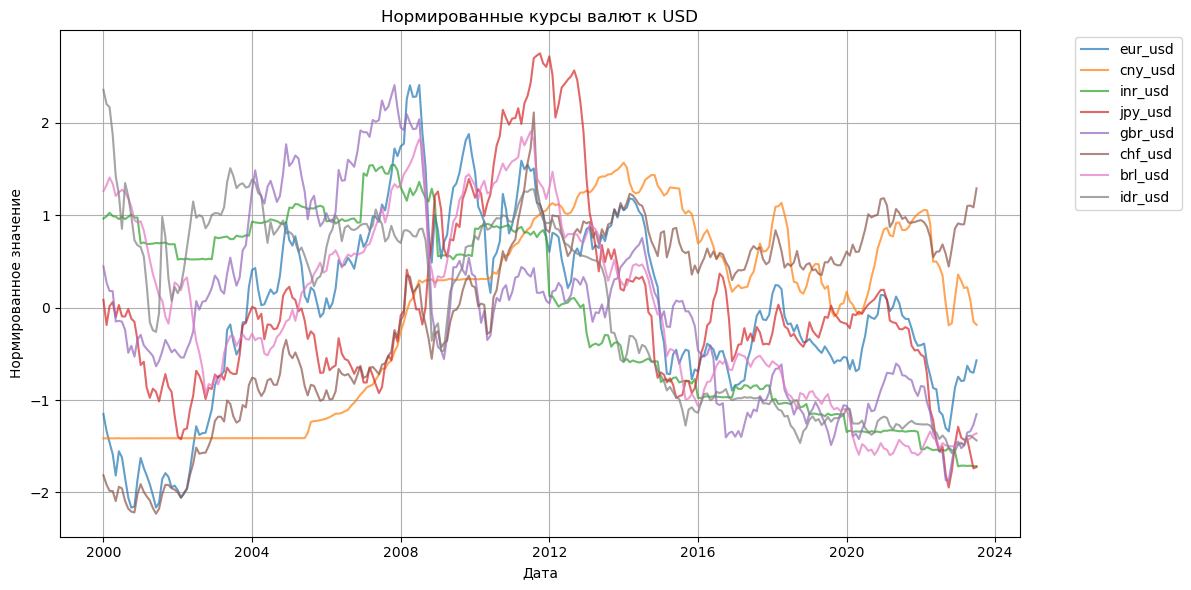

In [23]:
plt.figure(figsize=(12, 6))
for currency in scaled_currencies.columns:
    plt.plot(scaled_currencies.index, scaled_currencies[currency], label=currency, alpha=0.7)

plt.title('Нормированные курсы валют к USD')
plt.xlabel('Дата')
plt.ylabel('Нормированное значение')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

Можно ли выделить эти общие тренды на рынке? Да. Можно просто рассмотреть все валюты как один многомерный вектор и понизить его размерность. Либо оценить VAR-модель и вывести явно коинтеграционное соотношение (уравнение равновесия на рынке). Второй подход нам не подходит из-за малого количества данных для стольких уравнений, поэтому используем первый.

Конечно, для временных рядов существуют специфические методы понижения размерности, но они выходят за рамки нашего курса. Поэтому мы воспользуемся не слишком подходящим, но зато простым и знакомым методом главных компонент (PCA). PCA никак не учитывает временную зависимость точек, но мы позволим себе пренебречь этим.

### 2. (0.5 балла) Визуализация главных компонент

Примените PCA на рядах из восьми валют и отберите три первые главные компоненты. Изобразите их на одном графике. Сравните с предыдущим графиком. Компоненты будут примерно похожи на тренды нескольких разных групп валют.

In [24]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_currencies)

pca_df = pd.DataFrame(
    principal_components,
    index=currencies.index,
    columns=[f'PC{i+1}' for i in range(3)]
)

print("Объяснённая дисперсия:", pca.explained_variance_ratio_)

Объяснённая дисперсия: [0.51385857 0.33430362 0.08997749]


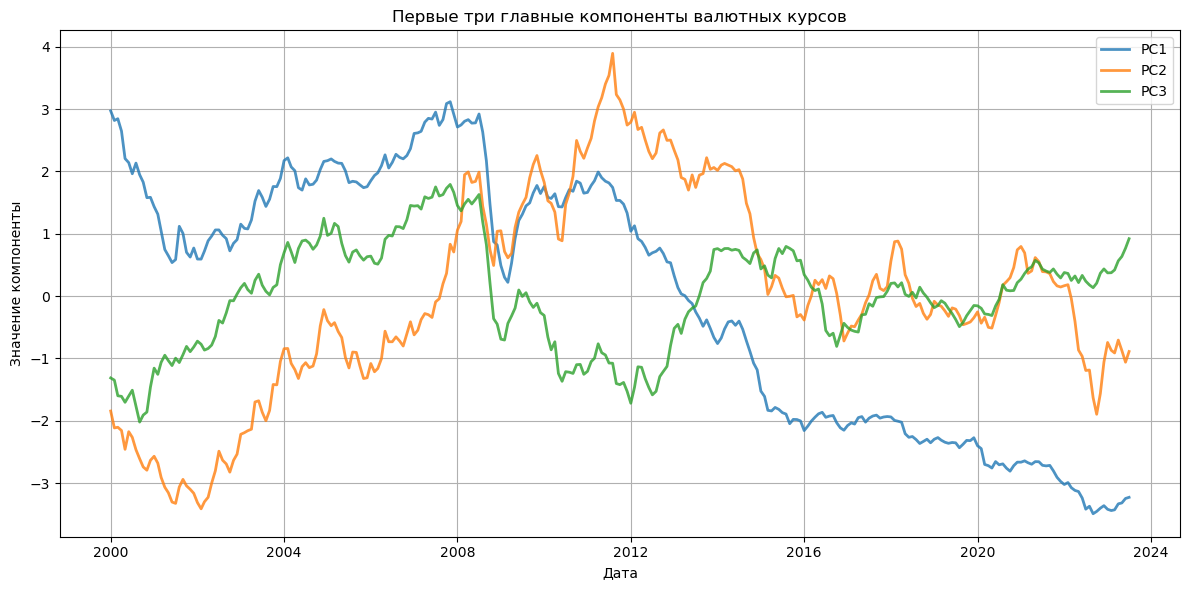

In [25]:
plt.figure(figsize=(12, 6))

for i in range(3):
    plt.plot(pca_df.index, pca_df[f'PC{i+1}'], label=f'PC{i+1}', alpha=0.8, linewidth=2)

plt.title('Первые три главные компоненты валютных курсов')
plt.xlabel('Дата')
plt.ylabel('Значение компоненты')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Итоговое замечание: На рынках есть некоторое глобальное равновесие (коинтеграционное соотношение). Если бы рядов было немного, мы могли бы построить VAR на нестационарных рядах за счёт этого общего тренда. Однако у нас такой возможности нет и придётся колхозить понижение размерности и строить на его основе стационарный VAR.

# 3. Автокодировщик на стероидах (5 баллов)

Попробуем обойти ограничение на количество рядов. Понизим размерность данных, построим VAR на двух-трёх мерном пространстве, а потом декодируем прогнозы.



 Модель будет устроена следующим образом.

1. Энкодер. Строим PCA на всех валютах (и доп фичах, если хотите) сразу, выделяем главные компоненты.
2. Декодер. PCA не обратим в стандартном понимании, нельзя аналитически получить из главных компонент обратно исходные ряды. Для каждой валюты обучаем регрессионную модель, предсказывающую курс валюты по главным компонентам. Если у нас 8 валют, здесь получится 8 моделей. Модели можно взять любые (линрег, бустинг, ...). Не мучайтесь с подбором гиперпараметров, бустинга из коробки хватит.
2. Строим VAR(p)-модель только на главных компонентах
4. Прогнозируем главные компоненты вперёд
5. Применяем модели-декодеры, чтобы получить из прогнозов главных компоненты прогнозы валют


(0.5 балла) Необходимо сделать препроцессинг данных, так как нам нужно будет строить VAR на стационарных рядах. Мы не уверены, что на PCA-рядах будет существовать коинтеграция. Приведите все ряды к стационарному виду.

In [26]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, name):
    result = adfuller(series.dropna())
    p_value = result[1]
    is_stationary = p_value < 0.05
    print(f"{name}: p-value = {p_value:.4f} | {'Стационарен' if is_stationary else 'Нестационарен'}")
    return is_stationary

for col in currencies.columns:
    check_stationarity(currencies[col], col)

eur_usd: p-value = 0.2149 | Нестационарен
cny_usd: p-value = 0.5278 | Нестационарен
inr_usd: p-value = 0.9577 | Нестационарен
jpy_usd: p-value = 0.5016 | Нестационарен
gbr_usd: p-value = 0.5292 | Нестационарен
chf_usd: p-value = 0.4686 | Нестационарен
brl_usd: p-value = 0.5401 | Нестационарен
idr_usd: p-value = 0.8254 | Нестационарен


In [27]:
stationary_currencies = currencies.diff(1).dropna()

for col in stationary_currencies.columns:
    check_stationarity(stationary_currencies[col], f"{col} (1-я разница)")

eur_usd (1-я разница): p-value = 0.0000 | Стационарен
cny_usd (1-я разница): p-value = 0.0000 | Стационарен
inr_usd (1-я разница): p-value = 0.0000 | Стационарен
jpy_usd (1-я разница): p-value = 0.0000 | Стационарен
gbr_usd (1-я разница): p-value = 0.0000 | Стационарен
chf_usd (1-я разница): p-value = 0.0000 | Стационарен
brl_usd (1-я разница): p-value = 0.0000 | Стационарен
idr_usd (1-я разница): p-value = 0.0000 | Стационарен


1. (0.5 балла) Реализуйте метод fit_pca, который вычисляет главные компоненты от всех валют и дополнительных переменных и сохраняет их. Компонент может быть не более трёх, либо не более 95% объяснённой дисперсии.

2. (0.5 балла) Реализуйте метод fit_var. В нём необходимо обучить VAR(p)-модель на главных компонентах из предыдущего пункта.

3. (1 балл) Реализуйте метод fit_decoders. Необходимо оценить ряд регрессий, восстанавливающих валюты из главных компонент. Восстанавливать дополнительные переменные не нужно. Заморачиваться с отбором параметров этих моделей не нужно (только при большом желании). Бустинга из коробки должно хватить.

4. (1 балл) Реализуйте метод forecast. VAR прогнозируют главные компоненты, а модели-декодеры восстанавливают из этих прогнозов валюты. Функция должна возвращать датафрейм прогнозов всех валют на 12 шагов. По строкам идут валюты, по столбцам -- горизонты.

In [28]:
from statsmodels.tsa.api import VAR
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import numpy as np

class EncoderDecoderForecaster:
    
    def __init__(self, data: pd.DataFrame, p= None):
        """
        __init__ Initializing forecaster class

        Arguments:
            data {pd.DataFrame} -- Dataframe of all data
            p {int} -- Order of VAR model
        """
        self.is_pca_fitted = False
        self.is_var_fitted = False
        self.is_decoder_fitted = False

        self.data = data
        self.p = p
        self.decoders = []
        self.scaler = StandardScaler()
        self.pca = None
        self.var_model = None
        
    def fit_pca(self, covered_variance=0.95, max_components=3) -> pd.DataFrame:
        """
        fit_pca Fitting PCA on a bunch of currencies

        Arguments:
            features {pd.DataFrame} -- Dataframe of features

        Keyword Arguments:
            covered_variance {float} -- Share of variance, covered by PCA from original data. (default: {0.95})
            max_components {int} -- Maximum number of PCA components, allowed for VAR. Have more priority than covered_variance.

        Returns:
            pd.DataFrame -- Dataframe of principal components
        """
        scaled_data = self.scaler.fit_transform(self.data)
        
        self.pca = PCA()
        pca_components = self.pca.fit_transform(scaled_data)
        
        explained_variance = np.cumsum(self.pca.explained_variance_ratio_)
        n_components = min(
            max_components,
            np.argmax(explained_variance >= covered_variance) + 1
        )
        
        self.pca = PCA(n_components=n_components)
        principal_components = self.pca.fit_transform(scaled_data)
        
        self.pca_components = pd.DataFrame(
            principal_components,
            index=self.data.index,
            columns=[f'PC{i+1}' for i in range(n_components)]
        )
        
        self.is_pca_fitted = True
        return self.pca_components

    def fit_var(self):
        """
        Fitting var on results of PCA
        """
        assert self.is_pca_fitted, "PCA must be fitted first"
        
        self.var_model = VAR(self.pca_components)
        if self.p is None:
            results = self.var_model.select_order()
            self.p = results.selected_orders['aic']
        
        self.var_model = self.var_model.fit(self.p)
        self.is_var_fitted = True

    def fit_decoders(self):
        """
        Fitting decoders from PCA to original data
        """
        assert self.is_pca_fitted, "PCA must be fitted first"
        
        X = self.pca_components.values
        y = self.data.values
        
        for i in range(y.shape[1]):
            gb = GradientBoostingRegressor()
            gb.fit(X, y[:, i])
            self.decoders.append(gb)
        
        self.is_decoder_fitted = True

    def forecast(self, h: int = 12) -> pd.DataFrame:
        """
        forecast Forecast VAR and decode it's forecasts with decoder-models.

        Keyword Arguments:
            h {int} -- Forecasting horizon (default: {1})

        Returns:
            pd.DataFrame -- Forecasts of all currencies. Horizon by columns. Currencies by rows.
        """
        assert self.is_pca_fitted and self.is_var_fitted and self.is_decoder_fitted, \
            "All components (PCA, VAR, decoders) must be fitted first"
        
        pca_forecast = self.var_model.forecast(self.pca_components.values[-self.p:], h)
        
        currency_forecasts = []
        for decoder in self.decoders:
            currency_forecasts.append(decoder.predict(pca_forecast))
        
        forecast_df = pd.DataFrame(
            np.array(currency_forecasts),
            index=self.data.columns,
            columns=[f'h_{i+1}' for i in range(h)]
        )
        
        return forecast_df

In [29]:
forecaster = EncoderDecoderForecaster(data=currencies, p=2)

forecaster.fit_pca()
forecaster.fit_var()
forecaster.fit_decoders()

forecasts = forecaster.forecast(h=12)
forecasts

,h_1,h_2,h_3,h_4,h_5,h_6,h_7,h_8,h_9,h_10,h_11,h_12
eur_usd,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923,1.124923
cny_usd,0.141939,0.141565,0.139839,0.139839,0.139839,0.139839,0.139972,0.140059,0.140233,0.140233,0.140233,0.140047
inr_usd,0.012171,0.012171,0.012403,0.012403,0.012403,0.012403,0.012416,0.012416,0.012416,0.012488,0.012488,0.012488
jpy_usd,0.727766,0.727766,0.732180,0.732180,0.732180,0.732180,0.732180,0.743496,0.743496,0.803843,0.803843,0.803843
gbr_usd,1.285720,1.285720,1.284423,1.284423,1.284423,1.284423,1.284423,1.284423,1.284423,1.284423,1.284423,1.284423
chf_usd,1.129788,1.129788,1.110101,1.110101,1.110101,1.110101,1.108332,1.108332,1.108332,1.108332,1.108332,1.108332
brl_usd,0.223927,0.226795,0.226795,0.226795,0.226795,0.226795,0.230623,0.230623,0.230623,0.230623,0.224862,0.224862
idr_usd,0.000067,0.000067,0.000068,0.000068,0.000068,0.000068,0.000068,0.000069,0.000069,0.000069,0.000069,0.000069


5. (1 балл) Отберите параметр p и посчитайте прогнозную ошибку такого метода для каждой валюты. 

    Предлагается следующая процедура. Пусть n - количество переменных в нашей модели (валюты + экзогенные по необходимости).

    1. Выбираем некоторое стартовое окно. У нас 283 точки. 36 (12*3) последних точек выделим на тестовую часть, остальное на тренировочную.
    2. На тренировочной части выбираем p по информационному критерию. В классе выше это означает p = None

    Далее попробуем получить наиболее репрезентативную оценку ошибки для такого p. Мы будем сразу считать относительную ошибку в сравнении с наивной моделью, так как на котировках часто нельзя построить статистическую модель лучше наивной. 

    1. Прогнозируем полученной моделью на 12 шагов вперёд по каждой валюте. (матрица размера [n, 12])
    2. Считаем абсолютную ошибку прогноза по каждой валюте и горизонту (матрица размера [n, 12])
    3. Строим наивный прогноз по каждой валюте  (матрица размера [n, 12]).
    4. Считаем абсолютную ошибку наивного прогноза по каждой валюте и горизонту  (матрица размера [n, 12])
    5. Считаем отношение ошибки нашего прогноза к наивной ошибке (поэлементно, матрица размера [n, 12])
    7. Увеличиваем тренировочную выборку на 6 наблюдений. Переоцениваем всю модель на новых данных, но уже при фиксированном p. В классе выше это будет p={некоторое число}

    Повторяем эту процедуру пока не закончатся данные. При текущих параметрах получится 4 итерации. Усредняем матрицы относительных ошибок поэлементно по всем итерациям. Итого получаем матрицу размера [n, 12].
    
    
    Параметры окон и горизонт можете поменять по собственным соображениям, но поясните логику.
    

In [30]:
def relative_cross_val_score_encoder_decoder(data: pd.DataFrame, initial_window_size: int, step: int, p, horizon: int = 12) -> pd.DataFrame:
    """
    cross_val_score Estimating MAE cross-val score on a fitted model. Needed to get more sustainable MAE estimation

    Arguments:
        data {pd.DataFrame} -- Input data
        initial_window_size {int} -- Initial size of expanding window
        step {int} -- Step size of expanding window
        p {int | None} -- order of VAR model (None for automatic selection)
        horizon {int} -- Forecasting horizon of cross-validation score
        
    Returns:
        pd.DataFrame -- Frame of relative error (model/naive) by each horizon and each currency, averaged by folds
    """
    
    total_points = len(data)
    n_currencies = data.shape[1]
    
    model_error_accum = np.zeros((n_currencies, horizon))
    naive_error_accum = np.zeros((n_currencies, horizon))
    fold_count = 0
    
    current_window_size = initial_window_size
    
    while current_window_size + horizon <= total_points:
        train_data = data.iloc[:current_window_size]
        test_data = data.iloc[current_window_size:current_window_size+horizon]
        
        model = EncoderDecoderForecaster(data=train_data, p=p)
        model.fit_pca()
        model.fit_var()
        model.fit_decoders()
        
        forecast = model.forecast(h=horizon)
        
        true_values = test_data.values.T
        model_errors = np.abs(forecast.values - true_values)
        
        naive_forecast = np.tile(train_data.iloc[-1].values.reshape(-1, 1), (1, horizon))
        naive_errors = np.abs(naive_forecast - true_values)
        
        model_error_accum += model_errors
        naive_error_accum += naive_errors
        fold_count += 1
        
        current_window_size += step
    
    avg_model_errors = model_error_accum / fold_count
    avg_naive_errors = naive_error_accum / fold_count
    
    relative_errors = avg_model_errors / avg_naive_errors
    
    error_df = pd.DataFrame(
        relative_errors,
        index=data.columns,
        columns=[f'h_{i+1}' for i in range(horizon)]
    )
    
    return error_df

6. (0.5 балла) Постройте графики скоров.

    1.  Каждая валюта представлена линией на графике
    2.  По оси абсцисс идёт горизонт прогнозирования (от 1 до 12)
    3.  По оси ординат отношение ошибки VAR-модели к ошибке наивной модели

Получилось ли по какой-то валюте стабильно предсказывать лучше наивной на всех горизонтах. По каким валютам получилось лучше, по каким хуже?

У нас получалось, что на сильно зарегулированных экономиках (например, Китай) прогнозы близки к наивным, так как курс валюты сильнее зависит от решений партии, а не внешней обстановки. Ваша постановка и данные несколько упрощены, поэтому не факт, что у вас получится воспроизвести этот эффект

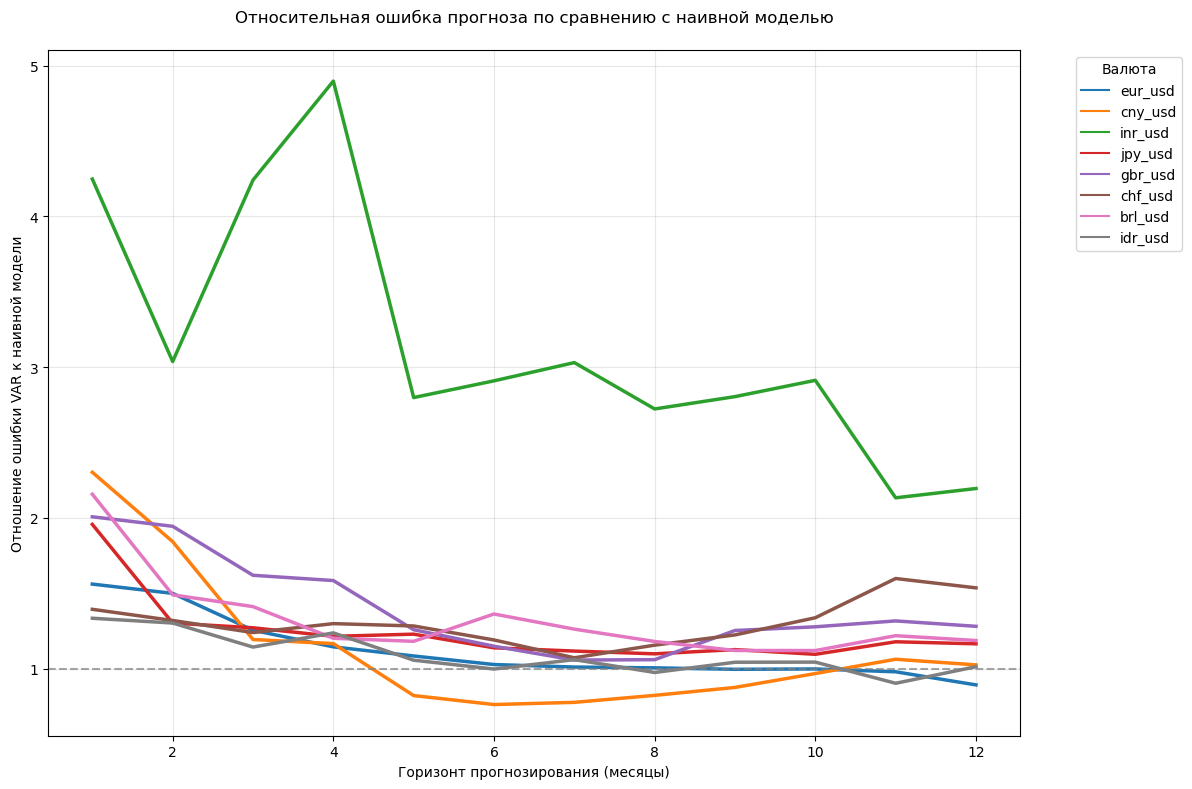

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_relative_errors(error_df):
    """
    Построение графиков относительных ошибок по валютам
    
    Аргументы:
        error_df {pd.DataFrame} - DataFrame с относительными ошибками (output relative_cross_val_score_encoder_decoder)
    """
    plt.figure(figsize=(12, 8))
    
    melted_errors = error_df.reset_index().melt(id_vars='index', var_name='horizon', value_name='relative_error')
    melted_errors['horizon'] = melted_errors['horizon'].str.extract('(\d+)').astype(int)
    
    sns.lineplot(data=melted_errors, x='horizon', y='relative_error', hue='index', 
                 palette='tab10', linewidth=2.5)
    
    plt.axhline(y=1, color='gray', linestyle='--', alpha=0.7)
    
    plt.title('Относительная ошибка прогноза по сравнению с наивной моделью', pad=20)
    plt.xlabel('Горизонт прогнозирования (месяцы)')
    plt.ylabel('Отношение ошибки VAR к наивной модели')
    plt.legend(title='Валюта', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    plt.show()

    
errors = relative_cross_val_score_encoder_decoder(
    data=currencies,
    initial_window_size=200,
    step=6,
    p=None,
    horizon=12
)

plot_relative_errors(errors)

# Расширения модели (До 3 баллов в зависимости от сложности модификации)

PCA -- не очень честный метод для временных рядов. Предложите, как можно скорректировать процедуру либо найдите метод понижения размерности специально для временных рядов. Кратко опишите суть и примените его для обоих классов выше вместо PCA. Получилось ли улучшить качество модели?

1. (1 балла) Ваше краткое описание методики и почему она подходит для рядов. Если есть статьи, можете приложить ссылки.

2. (2 балла) Реализация, подсчёт метрик и анализ результата.

In [ ]:
# ༼ つ ◕_◕ ༽つ не чето не хочу пока

##### Рубрика "как вам домашка?" (0.1 балла)

Пройдите короткий опрос. Это действительно важно. https://forms.gle/w3sV453spERTbGvr7